Animating particle dispersion from Parcels unto the Salish Sea Atlantis map

In [1]:
import os
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [2]:
# salish sea atlantis box shapefile.
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df = gpd.read_file(shapefile_name)
data_df = data_df.sort_values(by=['BOX_ID'])
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]


In [55]:
file_id = int(input( ))
scenario = {1 : "5b_Turn_Point_Diluted_bitumen",
            2 : "6a_VancouverHarbour_BunkerC",
            3 : "7a_JohnsonStrait_BunkerC",
            4 : "4a_ActivePass_Diesel",
            5 : "SandHeads",}

print("\nScenario running  :", scenario[file_id], sep = " ")


Scenario running  : 4a_ActivePass_Diesel


In [56]:
# Reading in the file generated by Ocean Parcels

release_start = '2020-07-01'
parcelsFileName = scenario[file_id] + str(release_start) + '_OP_D1000.nc'
#Atlantis_FileName = "Atlantis_" + scenario[file_id] + "_" + str(release_start) + ".nc"
#Atlantis_FileName = "BoxParticles_" + scenario[file_id] + "_" + str(release_start) + ".nc"

pfile = xr.open_dataset(str(parcelsFileName), decode_cf=True)

lon = np.ma.filled(pfile.variables['lon'], np.nan)
lat = np.ma.filled(pfile.variables['lat'], np.nan)
time = np.ma.filled(pfile.variables['time'], np.nan)
probs = np.ma.filled(pfile.variables['decay_value'], np.nan)
beached = np.ma.filled(pfile.variables['beached'], np.nan)

numParticles = lon.shape[0]
numObs = lon.shape[1]
print(numParticles)
print(numObs)

100
169


Plot the trajectories of the particles on the Atlantis map

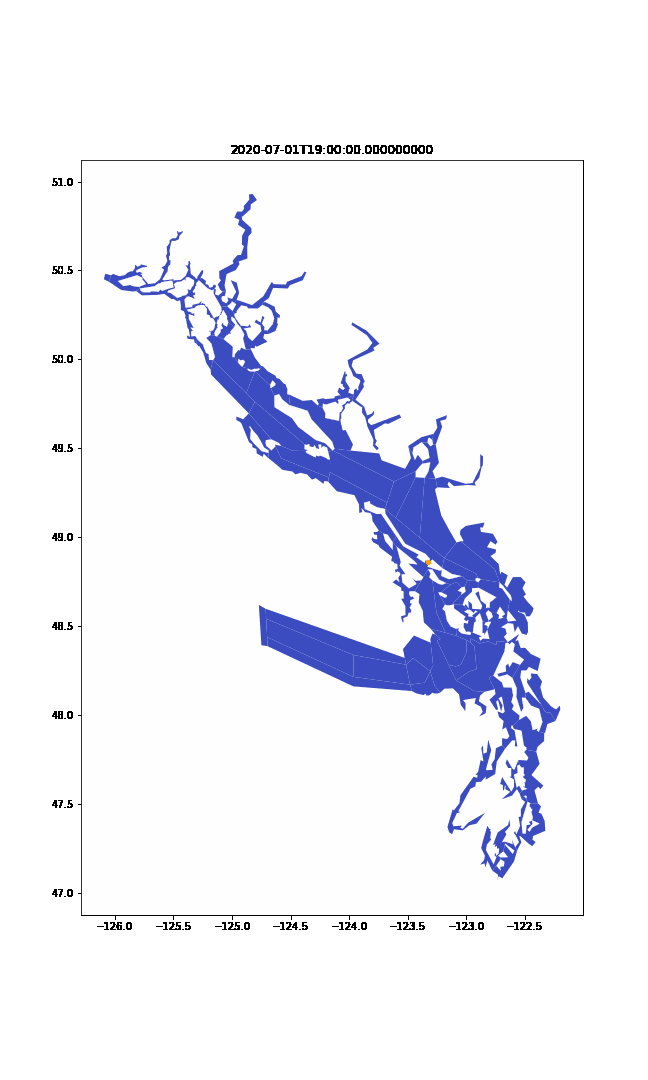

In [57]:
_cmap = cm.coolwarm #winter #viridis #Paired
file_names = []

land_df = data_df.loc[land_boxes]

for time_index in range(0, numObs):
    
    plon = lon[:, time_index]
    plat = lat[:, time_index]

    ax = data_df.plot(figsize=(9, 15), column = 'vertmix', cmap=_cmap, 
        vmin=0, vmax = 700,
        legend=False,
        )

    land_df.plot(ax=ax, color='white')
    ax.scatter(plon, plat, s=10, color='orange', zorder=20) #s=0.001
    ax.set_title(time[0][time_index])

    #plt.tight_layout()
    plot_name = 'particles_at_time_' + str(time_index).zfill(3) + '.png'
    plt.savefig(plot_name)
    file_names.append(plot_name)
    plt.close()

from PIL import Image
import glob
 
# Create the frames
frames = []
imgs = glob.glob("particles_at_time*.png")
imgs.sort() 
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)


# Save into loop
anim_name = 'Particle_trajectory_' + str(scenario[file_id]) + '_' + str(release_start) +'_D1000.gif'
frames[0].save(anim_name, format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=600, loop=0)

file_name_str = ' '.join(file_names)
os.system('rm ' + file_name_str)

# Plot image
from IPython.display import Image
with open(anim_name,'rb') as anim:
    display(Image(anim.read()))

In [58]:
beach_time = beached.sum(axis=0)
particles_beached = np.diff(beach_time)
t1 = (time[1,:] - time[1,0])/(3600000000000) #hours
t2 = (time[1,:] - time[1,0])/(3600000000000*24) #days
t_hours = t1[0:len(particles_beached)]
t_days = t2[0:len(particles_beached)]

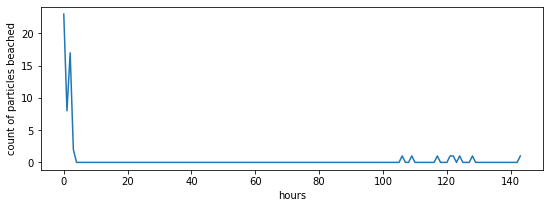

In [59]:
fig, ax = plt.subplots(figsize = (9,3))
ax.plot(t_hours, particles_beached)
ax.set_xlabel('hours')
ax.set_ylabel('count of particles beached');
#np.histogram(beach_time)

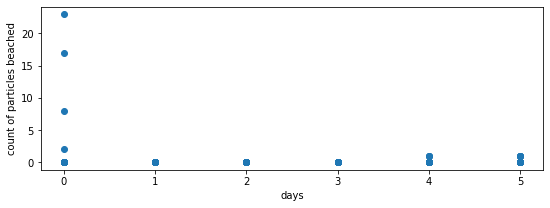

In [60]:
fig, ax = plt.subplots(figsize = (9,3))

ax.plot(t_days, particles_beached, 'o')
ax.set_xlabel('days')
ax.set_ylabel('count of particles beached');
#np.histogram(beach_time)

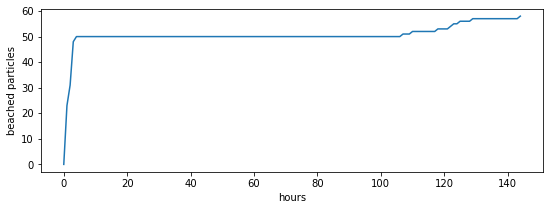

In [61]:
fig, ax = plt.subplots(figsize = (9,3))

ax.plot(t1, beach_time)
ax.set_xlabel('hours')
ax.set_ylabel('beached particles');